# Statistics to Correct for Alignment Issues

This notebook is designed to see measure how words change through time. After alignment and distance calculations have been performed, the next step is to visualize these changes. Best way is through heatmaps that are shown below. One issue here is that alignment isn't the magic solution for the early year bias found in [02_umap_alignment_check.ipynb](../alignment_check_experiment/02_umap_alignment_check.ipynb). An approach to account for this bias is to randomly sample tokens that are shared across all years (2000-2020) to capture the variance between models. Following the sample process, I calculated z_scores for each year pair to see if I can correct for this bias.

In [1]:
from pathlib import Path
import itertools

import numpy as np
import pandas as pd
import plotnine as p9
from plydata import (
    query,
    group_by,
    select,
    if_else,
    summarize,
    pull,
    define,
    sample_n,
    do,
    arrange,
)
from plydata.tidy import extract

from biovectors_modules.plot_helper import plot_local_global_distances

# Load Data

In [2]:
distance_file = "output/all_year_distances.tsv.xz"
if not Path(distance_file).exists():
    data_df = []
    for file in Path("output").rglob("*part*.tsv"):
        data_df.append(pd.read_csv(file, sep="\t"))
    data_df = pd.concat(data_df).sort_values("token")
    data_df.to_csv(distance_file, sep="\t", index=False, compression="xz")
else:
    data_df = pd.read_csv(distance_file, sep="\t")
data_df.sample(100, random_state=100)

,token,global_dist,local_dist,year_pair
405887,fly,0.221866,0.003224,2011-2014
93798,affects,0.138509,0.003935,2008-2015
1828695,amhr2,0.402701,0.008533,2016-2019
26768,14.2,0.239945,0.014263,2005-2014
35402,1985,0.181526,0.005073,2007-2011
...,...,...,...,...
1800593,ubiquitins,0.672144,0.085384,2014-2018
1702438,fpl,0.633827,0.011140,2019-2020
1758875,papule,0.327582,0.005054,2017-2018
2043947,vccs,0.695065,0.137383,2015-2016


In [3]:
tokens = (
    data_df
    >> query("year_pair.str.contains('2000-2001')")
    >> sample_n(1000, random_state=100)
    >> pull("token")
)
tokens

array(['0.011', 'local', 'alkylating', 'norwegian', 'p16', '-induced',
       'underwent', 'senses', 'begin', 'properly', 'connexins', 'maximal',
       'parkinsonism', 'striated', 'residences', '108', 'upa', 'computer',
       'kit', '0.44', 'surgically', 'massachusetts', 'malignancy',
       'bears', '1.63', 'context', 'distilled', 'methylene', 'days',
       'phosphatase', 'lapse', 'axes', 'allele', 'player', '38.2',
       'style', '~10', 'ca2', 'unusually', 'another', 'meconium', 'stalk',
       'assign', 'overwhelming', 'angular', 'fresh', 'l-1', 'hernia',
       'responding', 'ensuing', 'enforced', '27', 'isolate', 'vertebrate',
       'rotating', 'serogroups', 'sensitizing', 'ecs', 'ers',
       'disassembled', 'monomers', 'ossification', 'precancerous',
       'cofactors', 'liposomal', 'largely', 'ada', 'electrospray', 'be',
       'nucleosides', 'lyse', 'similarity', 'neuron', 'patches', 'like',
       'gold', 'residual', '1.00', 'splenomegaly', 'gastroenteritis',
       'il)

# Calculate Z scores from the Data

In [4]:
z_score_df = (
    data_df
    >> query("token in @tokens")
    >> group_by("year_pair")
    >> summarize(
        global_mean="np.mean(global_dist)",
        global_std="np.std(global_dist)",
        local_mean="np.mean(local_dist)",
        local_std="np.std(local_dist)",
    )
)
z_score_df

,year_pair,global_mean,global_std,local_mean,local_std
0,2000-2002,0.234375,0.215518,0.049241,0.145412
1,2008-2012,0.258410,0.118161,0.024369,0.048761
2,2004-2006,0.293963,0.150182,0.038401,0.080625
3,2004-2005,0.253758,0.164135,0.031063,0.080709
4,2003-2020,0.666197,0.133605,0.339315,0.183748
...,...,...,...,...,...
205,2019-2020,0.168724,0.093074,0.005390,0.016410
206,2008-2009,0.214849,0.115109,0.012059,0.026696
207,2000-2001,0.214195,0.210235,0.042196,0.133034
208,2008-2011,0.239799,0.113729,0.017796,0.035977


In [5]:
years = [
    f"{pair[0]}-{pair[1]}"
    for pair in itertools.combinations(range(2000, 2021), 2)
    if pair[1] - pair[0] == 1
]

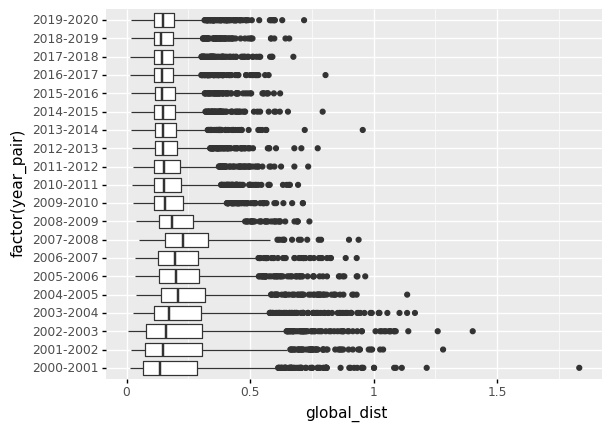

In [6]:
g = (
    p9.ggplot(
        data_df >> query("token in @tokens&year_pair in @years"),
        p9.aes(x="factor(year_pair)", y="global_dist"),
    )
    + p9.geom_boxplot()
    + p9.coord_flip()
)
print(g)

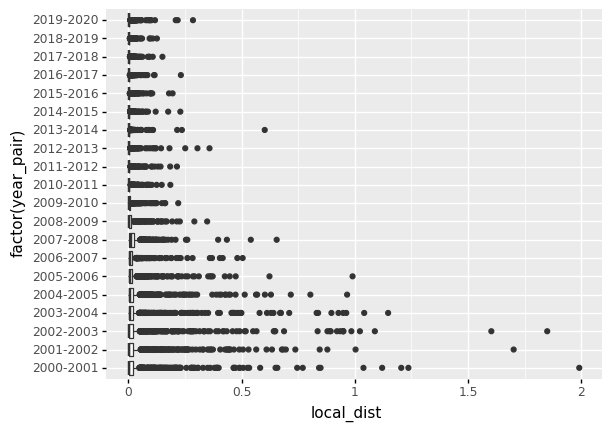

In [7]:
g = (
    p9.ggplot(
        data_df >> query("token in @tokens&year_pair in @years"),
        p9.aes(x="factor(year_pair)", y="local_dist"),
    )
    + p9.geom_boxplot()
    + p9.coord_flip()
)
print(g)

In [8]:
year_pair_mapper = z_score_df.set_index("year_pair").to_dict("index")

In [9]:
plot_df = (
    data_df.append(pd.read_csv("caov3_fixed.tsv", sep="\t", index_col=0)).append(
        pd.read_csv("crispr_fixed.tsv", sep="\t", index_col=0)
    )
    >> define(
        z_global_dist=lambda x: (
            x.global_dist
            - x.year_pair.apply(lambda pair: year_pair_mapper[pair]["global_mean"])
        )
        / x.year_pair.apply(lambda pair: year_pair_mapper[pair]["global_std"]),
        z_local_dist=lambda x: (
            x.global_dist
            - x.year_pair.apply(lambda pair: year_pair_mapper[pair]["local_mean"])
        )
        / x.year_pair.apply(lambda pair: year_pair_mapper[pair]["local_std"]),
    )
    >> extract("year_pair", into=["year_origin", "year_compared"], regex=r"(\d+)-(\d+)")
)
plot_df

,token,global_dist,local_dist,year_origin,year_compared,z_global_dist,z_local_dist
208,,0.107845,0.001138,2018,2020,-0.676472,5.601433
75,,0.485900,0.100155,2004,2006,1.278030,5.550339
74,,0.309318,0.048704,2004,2005,0.338501,3.447633
73,,0.771058,0.495530,2003,2020,0.784859,2.349651
72,,0.759678,0.501860,2003,2019,0.610189,2.083224
...,...,...,...,...,...,...,...
115,crispr,0.132712,0.001531,2017,2019,-0.367090,13.127275
116,crispr,0.110264,0.001695,2017,2020,-0.670535,5.374146
117,crispr,0.126909,0.001697,2018,2019,-0.401750,13.826396
118,crispr,0.092192,0.000951,2018,2020,-0.844299,4.743432


# Plot Token Distances

In [10]:
figure_dir = Path("output/distance_heatmaps")

## Are Token

In [11]:
global_plot, local_plot, z_global_plot, z_local_plot = plot_local_global_distances(
    plot_df, "are"
)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/are_global_heatmap.png


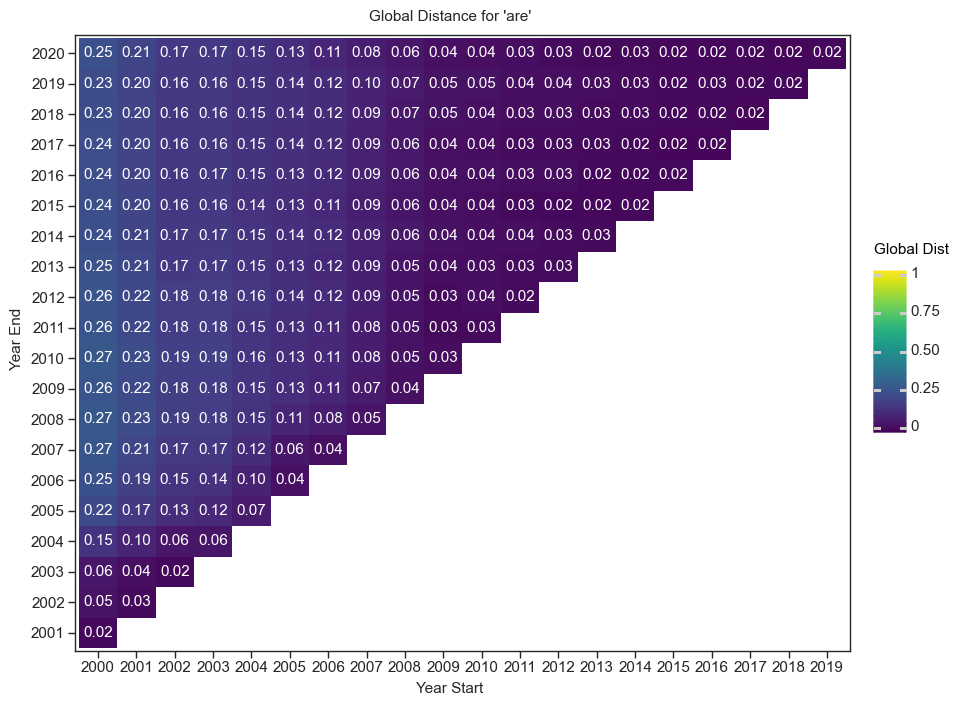

<ggplot: (8741844144104)>

In [12]:
global_plot.save(f"{figure_dir}/are_global_heatmap.png", dpi=150)
global_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/are_local_heatmap.png


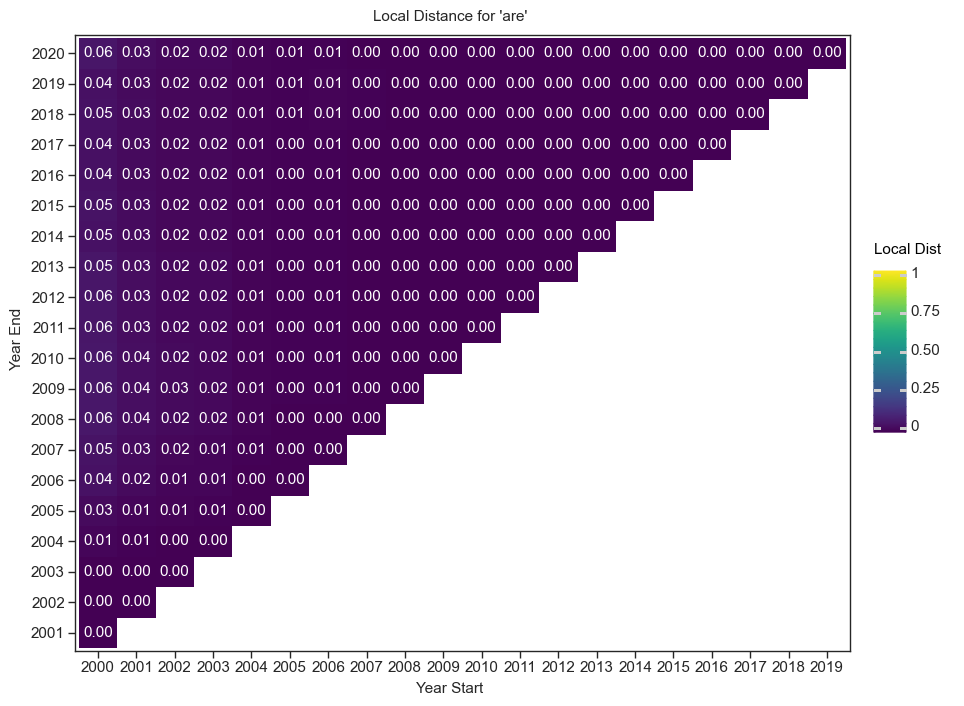

<ggplot: (-9223363295010654653)>

In [13]:
local_plot.save(f"{figure_dir}/are_local_heatmap.png", dpi=150)
local_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/are_z_global_heatmap.png


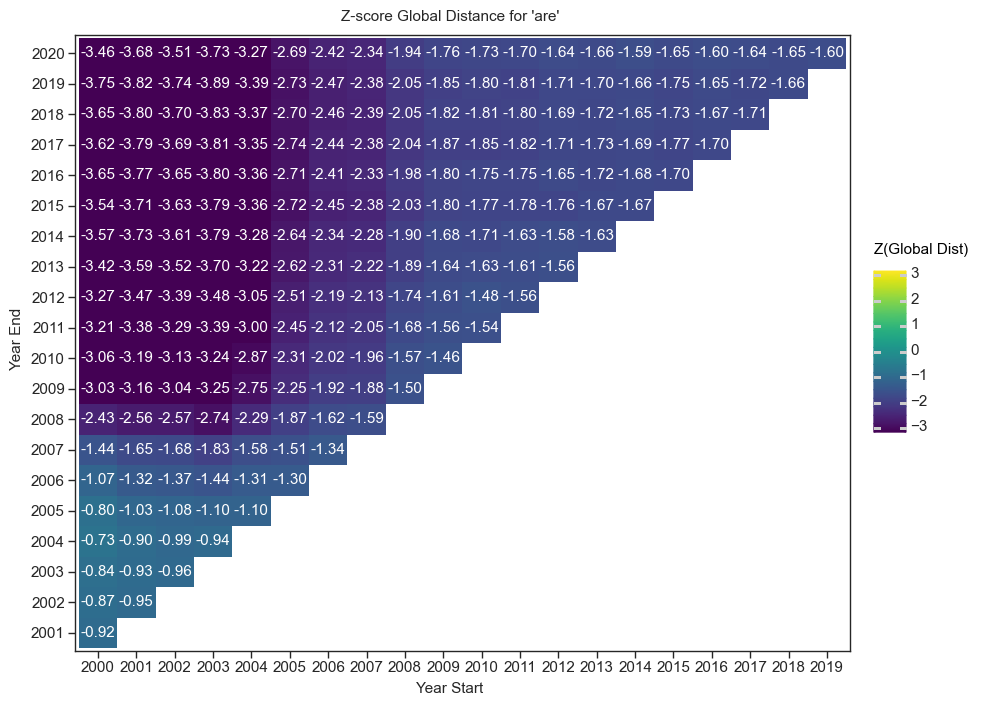

<ggplot: (-9223363295010548543)>

In [14]:
z_global_plot.save(f"{figure_dir}/are_z_global_heatmap.png", dpi=150)
z_global_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/are_z_local_heatmap.png


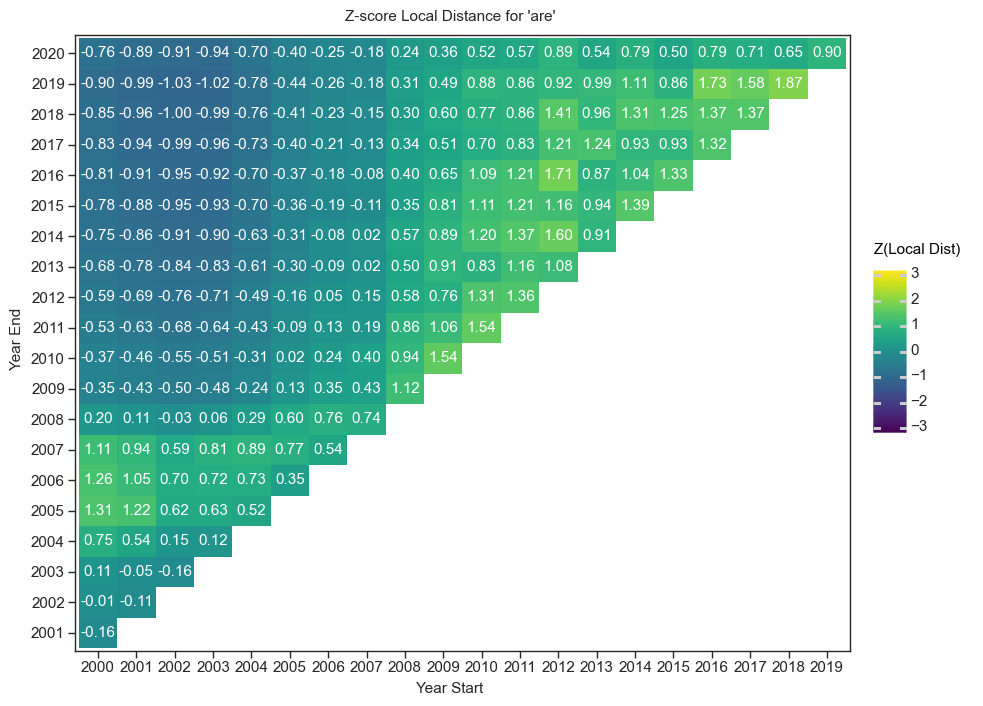

<ggplot: (8741842334742)>

In [15]:
z_local_plot.save(f"{figure_dir}/are_z_local_heatmap.png", dpi=150)
z_local_plot

## Interleukin-18

In [16]:
global_plot, local_plot, z_global_plot, z_local_plot = plot_local_global_distances(
    plot_df, "interleukin-18"
)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/interleukin-18_global_heatmap.png


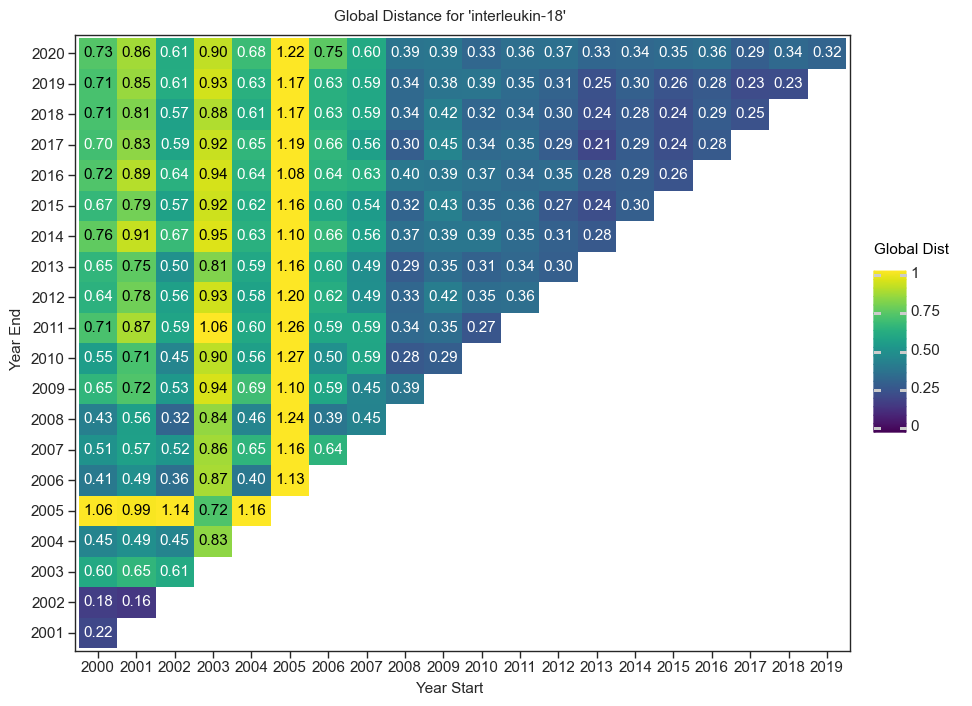

<ggplot: (-9223363295052601817)>

In [17]:
global_plot.save(f"{figure_dir}/interleukin-18_global_heatmap.png", dpi=150)
global_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/interleukin-18_local_heatmap.png


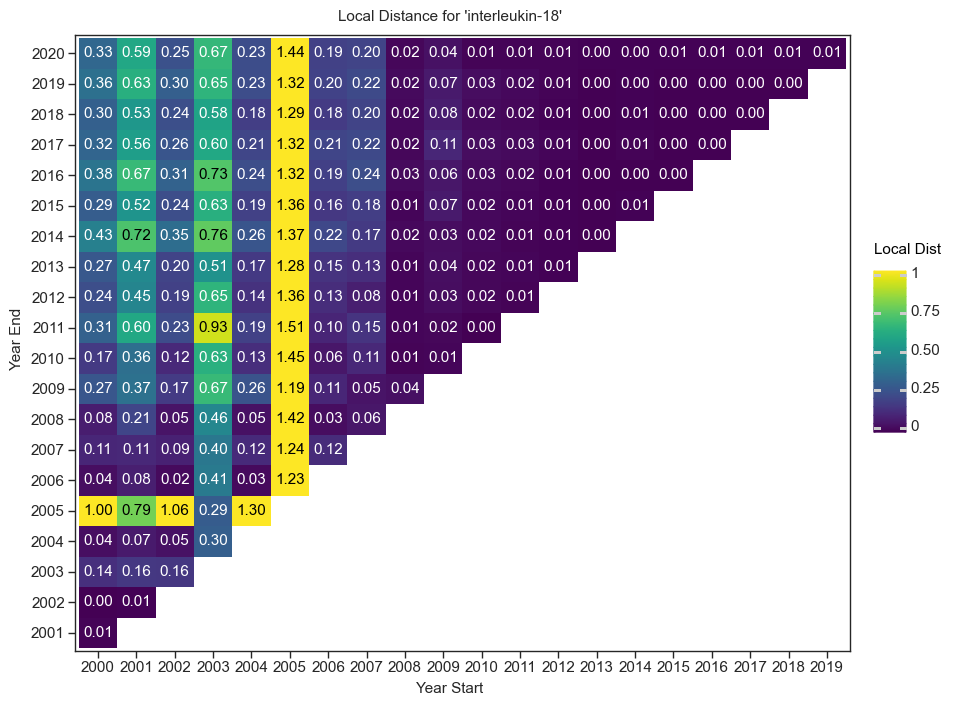

<ggplot: (-9223363295053480416)>

In [18]:
local_plot.save(f"{figure_dir}/interleukin-18_local_heatmap.png", dpi=150)
local_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/interleukin-18_z_global_heatmap.png


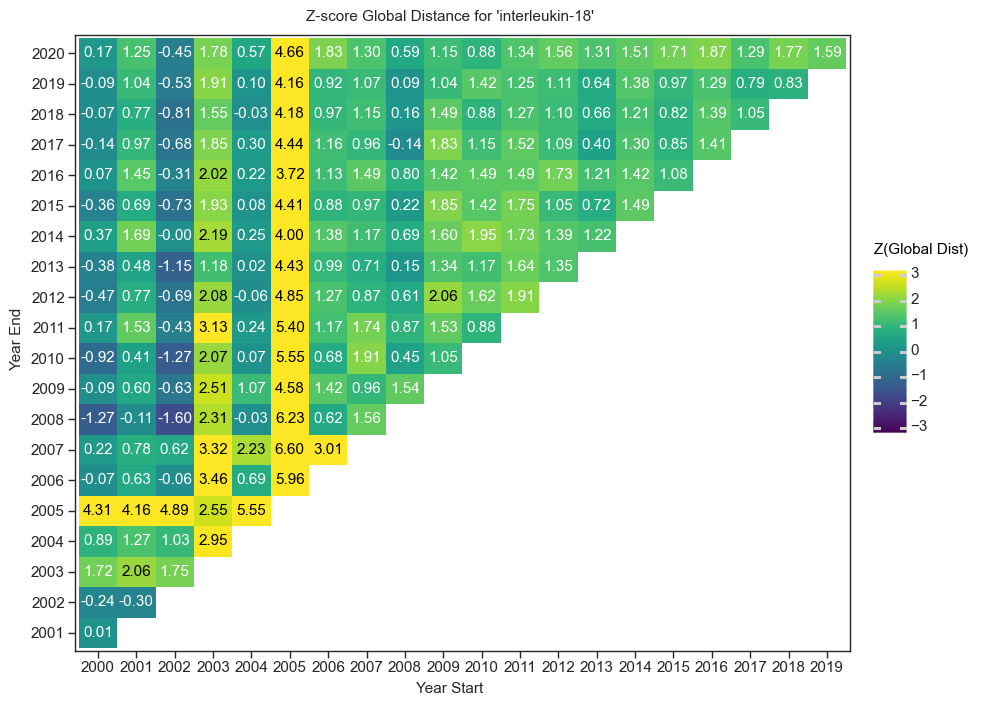

<ggplot: (8741801282266)>

In [19]:
z_global_plot.save(f"{figure_dir}/interleukin-18_z_global_heatmap.png", dpi=150)
z_global_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/interleukin-18_z_local_heatmap.png


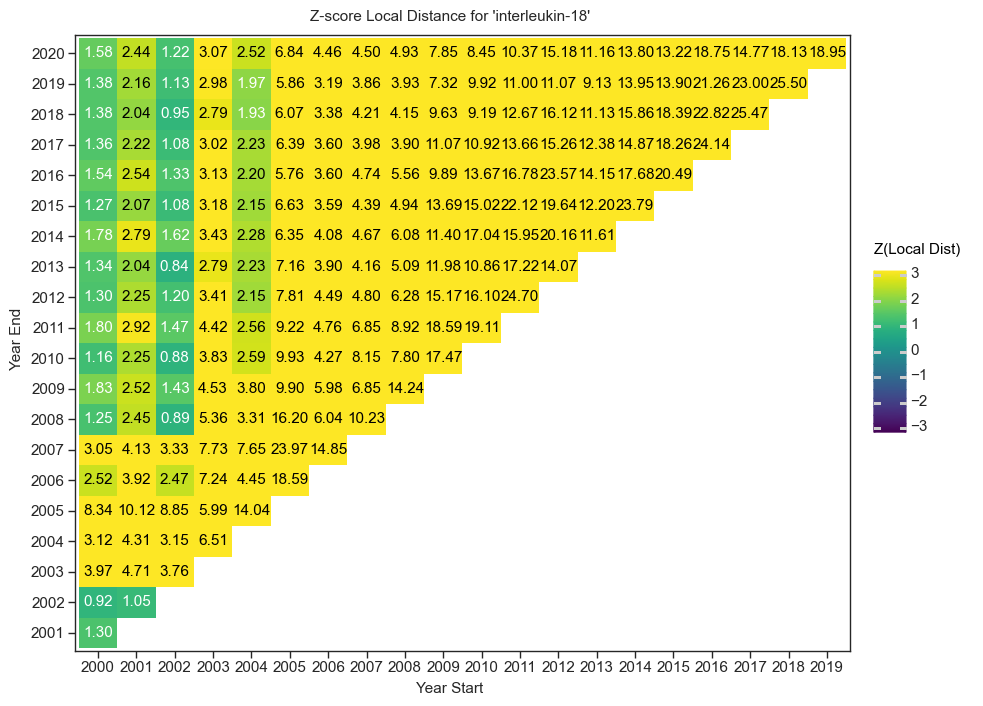

<ggplot: (-9223363295053524434)>

In [20]:
z_local_plot.save(f"{figure_dir}/interleukin-18_z_local_heatmap.png", dpi=150)
z_local_plot

## Crispr

In [21]:
global_plot, local_plot, z_global_plot, z_local_plot = plot_local_global_distances(
    plot_df, "crispr"
)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/crispr_global_heatmap.png


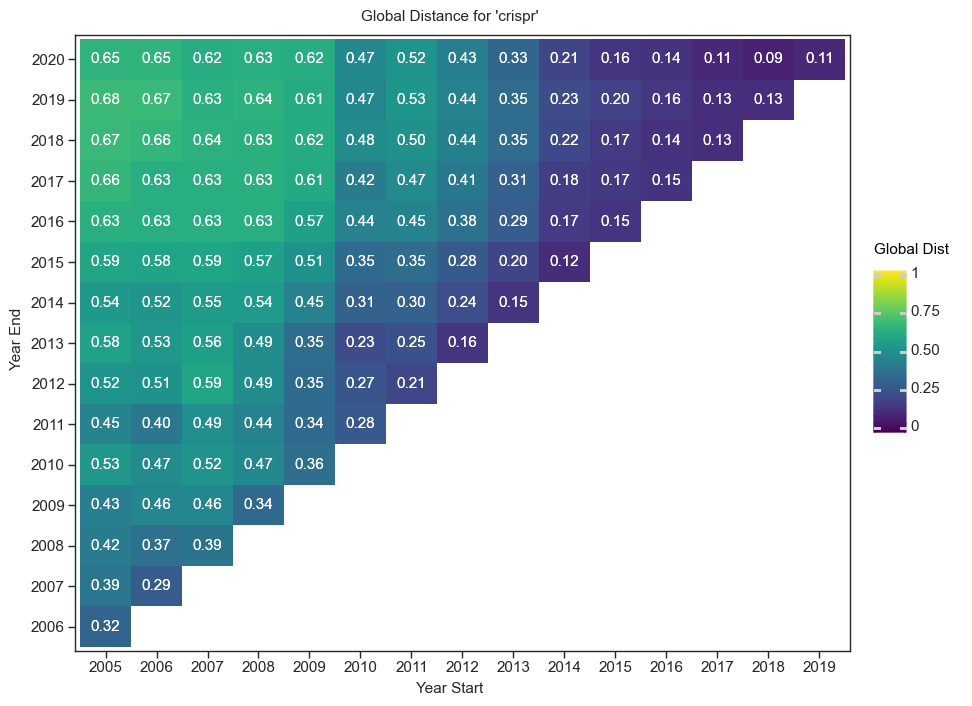

<ggplot: (-9223363295066360260)>

In [22]:
global_plot.save(f"{figure_dir}/crispr_global_heatmap.png", dpi=150)
global_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/crispr_local_heatmap.png


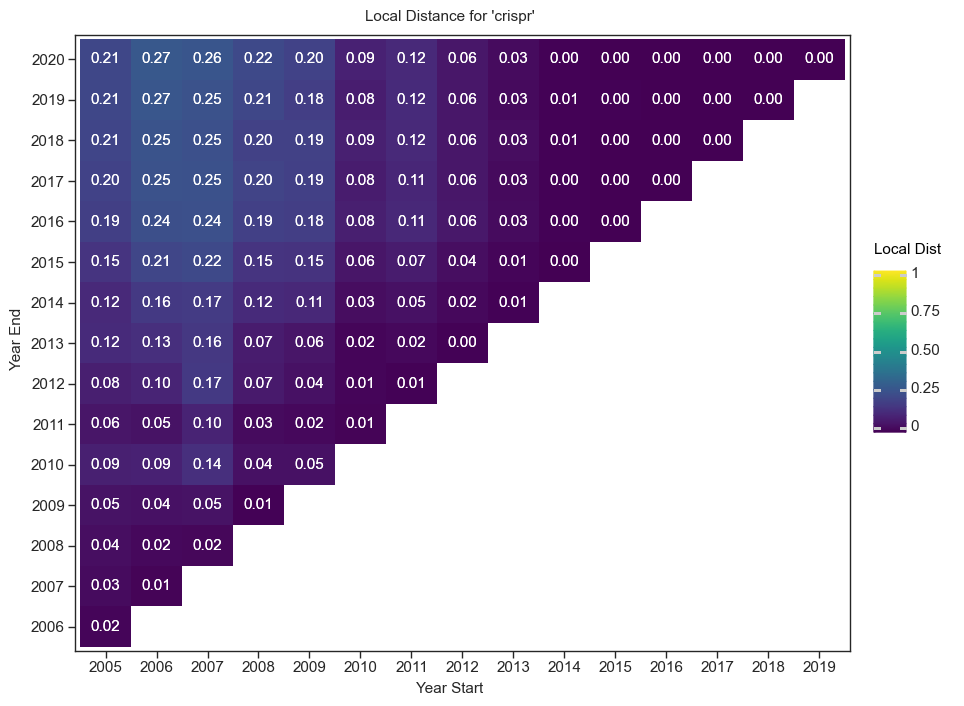

<ggplot: (8741788381767)>

In [23]:
local_plot.save(f"{figure_dir}/crispr_local_heatmap.png", dpi=150)
local_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/crispr_z_global_heatmap.png


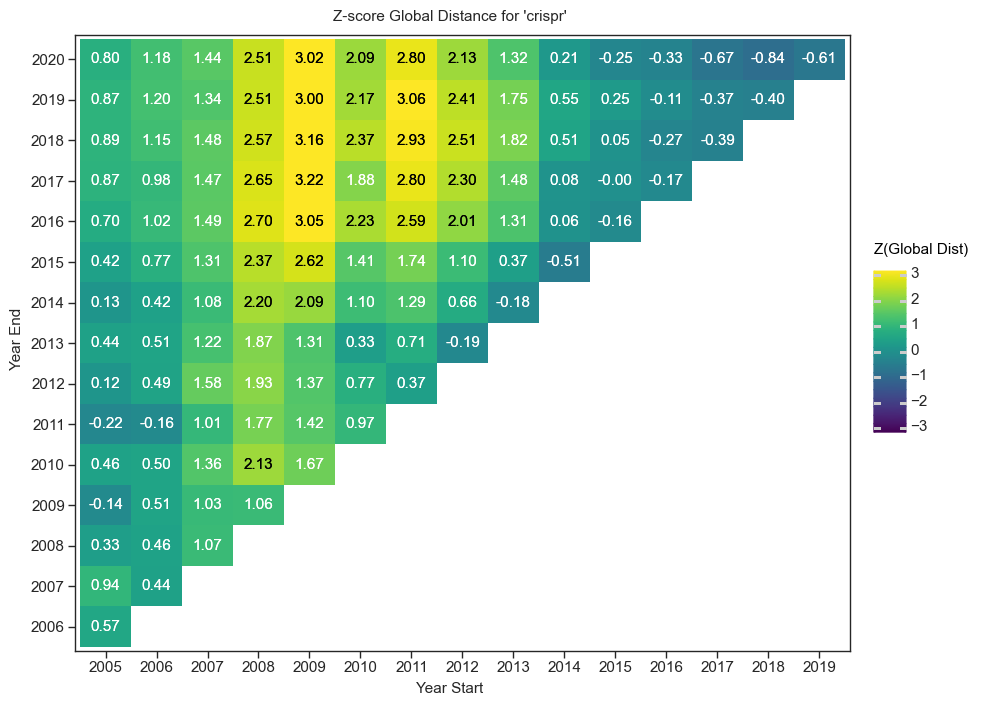

<ggplot: (8741789067293)>

In [24]:
z_global_plot.save(f"{figure_dir}/crispr_z_global_heatmap.png", dpi=150)
z_global_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/crispr_z_local_heatmap.png


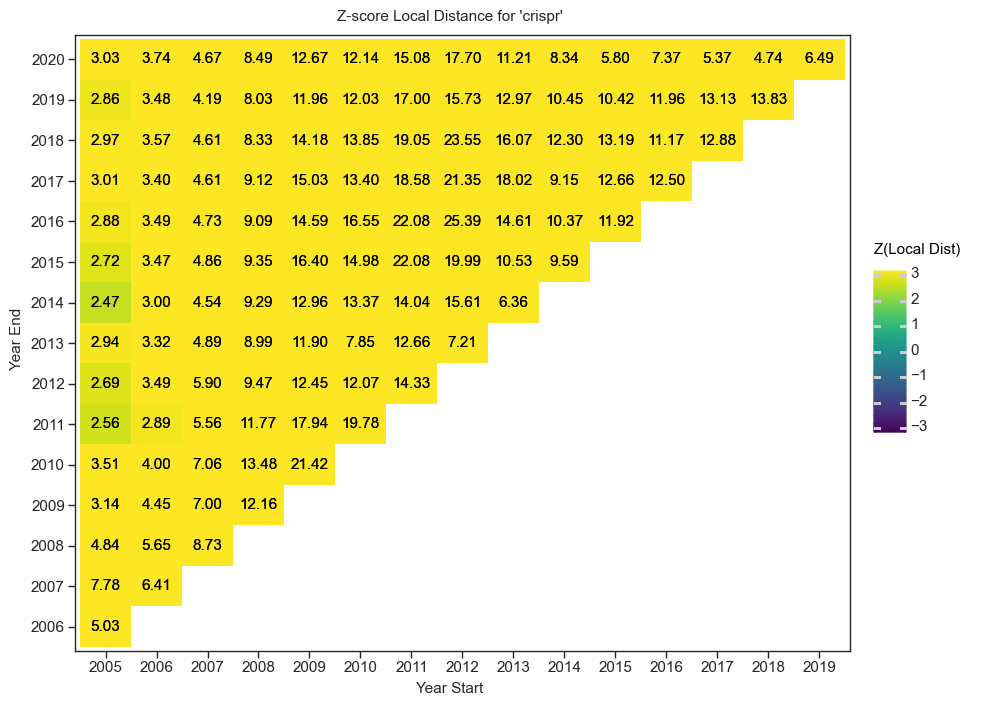

<ggplot: (-9223363295066518107)>

In [25]:
z_local_plot.save(f"{figure_dir}/crispr_z_local_heatmap.png", dpi=150)
z_local_plot

## Caov3

In [26]:
global_plot, local_plot, z_global_plot, z_local_plot = plot_local_global_distances(
    plot_df, "caov3"
)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/caov3_global_heatmap.png


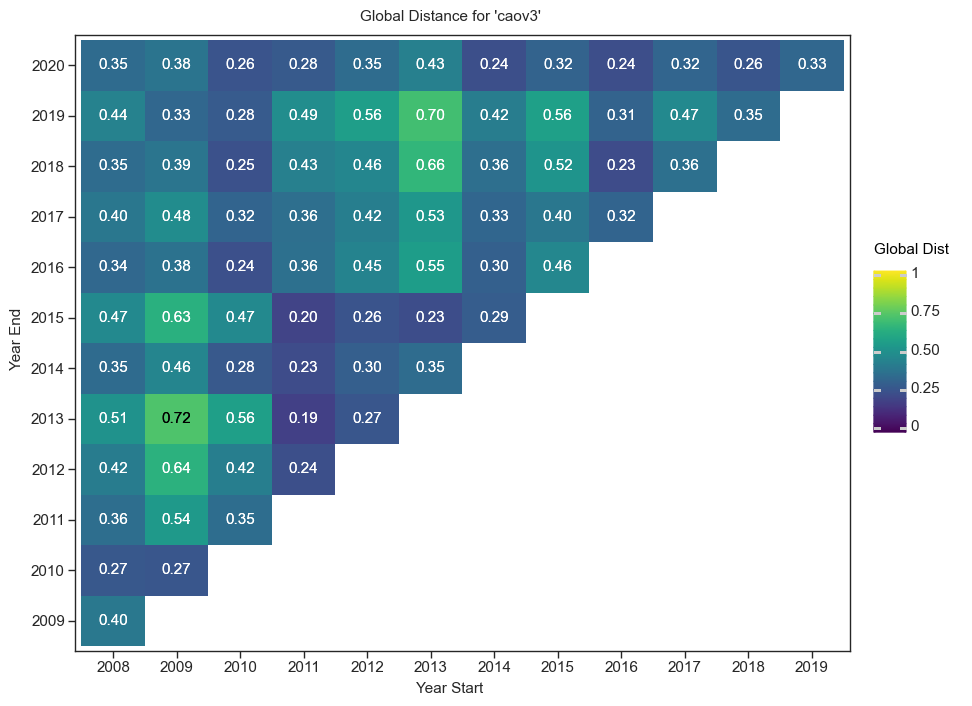

<ggplot: (8741783064100)>

In [27]:
global_plot.save(f"{figure_dir}/caov3_global_heatmap.png", dpi=150)
global_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/caov3_local_heatmap.png


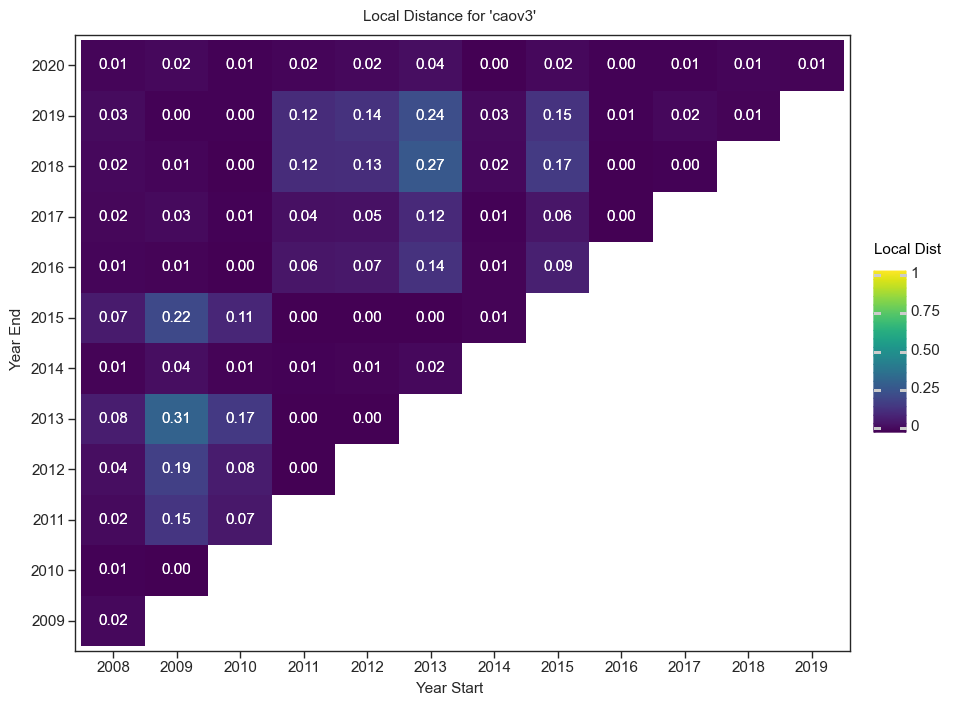

<ggplot: (8741782115483)>

In [28]:
local_plot.save(f"{figure_dir}/caov3_local_heatmap.png", dpi=150)
local_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/caov3_z_global_heatmap.png


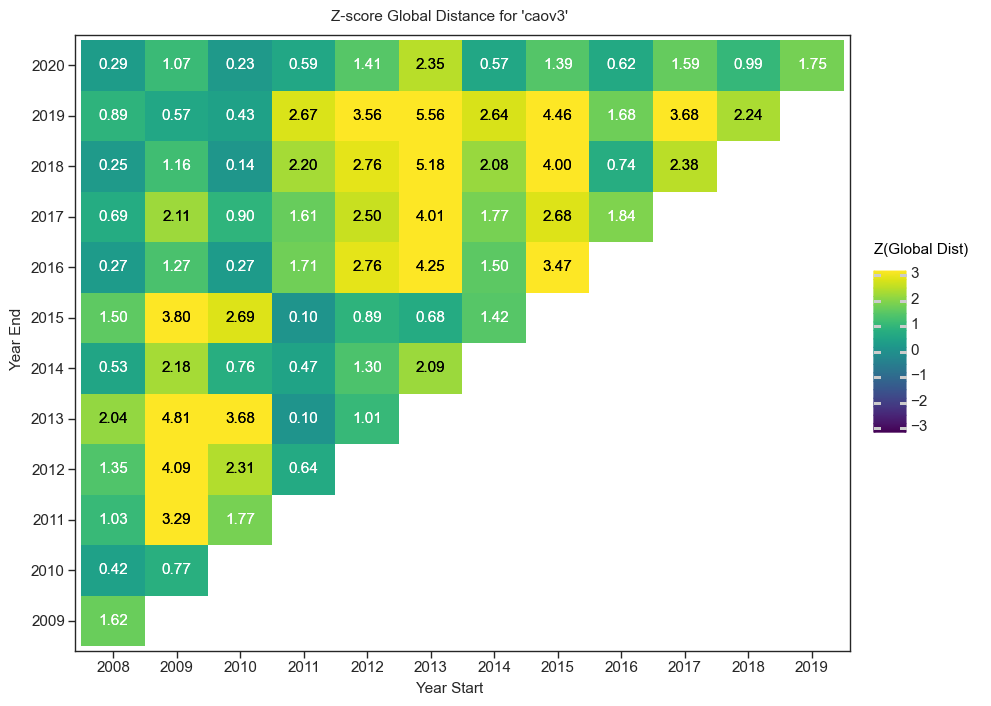

<ggplot: (8741781296339)>

In [29]:
z_global_plot.save(f"{figure_dir}/caov3_z_global_heatmap.png", dpi=150)
z_global_plot

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 10 x 8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: output/distance_heatmaps/caov3_z_local_heatmap.png


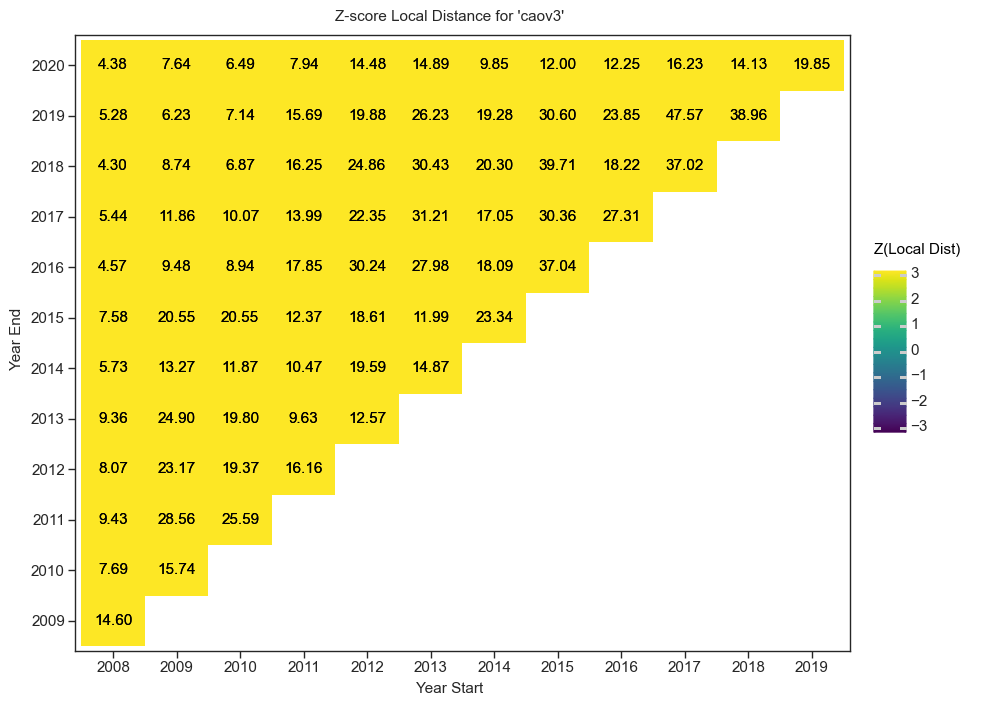

<ggplot: (8741781266801)>

In [30]:
z_local_plot.save(f"{figure_dir}/caov3_z_local_heatmap.png", dpi=150)
z_local_plot

# Conclusion

1. Stop words are a great negative control to show how words shouldn't change through time.
2. CRISPR is a great positive shows how the vector is changing through time with the change being stable after 2009.
3. Interleukin 18 seems to have a change in the year 2005, but the open problem here is that 2005 may not be aligned correctly which results in this "seemingly" positive result.
4. The random sample approach doesn't appear to fix this bias issue so I might have to find another approach to account for this early year bias.